In [1]:
!nvidia-smi

Mon Oct 11 03:18:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install extra-keras-datasets

In [14]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
from extra_keras_datasets import emnist

In [15]:
(x_train, y_train),(x_test_ori, y_test) = emnist.load_data(type='byclass')

INFO:root:Loading dataset = emnist


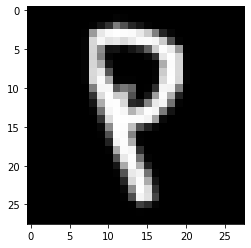

In [16]:
plt.imshow(x_test_ori[3000], cmap="gray") # Import the image
plt.show() # Plot the image

In [17]:
# reshape to be [samples][width][height][channels]
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32')
x_test = x_test_ori.reshape((x_test_ori.shape[0], 28, 28, 1)).astype('float32')

In [18]:
# normalize inputs from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255
# one hot encode outputs for the loss funtion
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [19]:
# define the 2-layer CNN model
def cnn_model(dpout, opt, first_hidden, second_hidden, first_kernel, second_kernel, loss_f):
	# create model
	model = Sequential()
	model.add(Conv2D(first_hidden, (first_kernel, first_kernel), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Conv2D(second_hidden, (second_kernel, second_kernel), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Dropout(dpout))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss=loss_f, optimizer=opt, metrics=['accuracy'])
	return model

In [20]:
def plot_line_all(title, x_label, y_label, inputs, legends):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    for inp in inputs:
        plt.plot(inp)
    plt.legend(legends, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.grid()
    plt.show()

In [ ]:
# hyperparameters = [[0.2, 75, 75, 75, 5, 3, 3, 0.0001, 128, 'categorical_crossentropy'],
#                    [0.2, 90, 90, 90, 5, 3, 3, 0.0001, 128, 'categorical_crossentropy'],
#                    [0.2, 100, 100, 100, 5, 3, 3, 0.0001, 128, 'categorical_crossentropy']]
# hyperparameters = [[0.2, 100, 100, 100, 3, 3, 3, 0.0001, 128, 'categorical_crossentropy'],
#                    [0.2, 100, 100, 100, 5, 3, 3, 0.0001, 128, 'categorical_crossentropy'],
#                    [0.2, 100, 100, 100, 5, 5, 3, 0.0001, 128, 'categorical_crossentropy']]
# hyperparameters = [[0.2, 100, 100, 100, 5, 5, 3, 0.001, 128, 'categorical_crossentropy'],
#                    [0.2, 100, 100, 100, 5, 5, 3, 0.0001, 128, 'categorical_crossentropy']]
hyperparameters = [[0.5, 256, 128, 5, 3, 0.001, 256, 'categorical_crossentropy']]
i = 0
history = []
strhyp = []
for dpout, hid1, hid2, ker1, ker2, lr, bs, ls in hyperparameters:
    keras.backend.clear_session()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model = cnn_model(dpout, opt, hid1, hid2, ker1, ker2, ls)
    history.append(model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=bs))
    i += 1
    strhyp.append("dp: " + str(dpout) +" hid1: " + str(hid1) +" hid2: " + str(hid2) +" ker1: " + str(ker1) +" ker2: " + str(ker2) +" lr: " + str(lr) +" bs: " + str(bs) + " loss: "+ ls)
    
    tloss, tacc = model.evaluate(x=x_test, y=y_test)
    print('\nTest accuracy:', tacc, ' Test loss:', tloss)

acc = []
loss = []
for his in history:
    acc.append(his.history['val_accuracy'])
    loss.append(his.history['val_loss'])

# summarize history for accuracy
plot_line_all('model accuracy', 'epoch', 'accuracy', acc, strhyp)
# summarize history for loss
plot_line_all('model loss', 'epoch', 'loss', loss, strhyp)

Epoch 1/20
2182/2182 [==============================] - 145s 53ms/step - loss: 0.6224 - accuracy: 0.8002 - val_loss: 0.4262 - val_accuracy: 0.8465
Epoch 2/20
2182/2182 [==============================] - 113s 52ms/step - loss: 0.4254 - accuracy: 0.8470 - val_loss: 0.3857 - val_accuracy: 0.8594
Epoch 3/20
2182/2182 [==============================] - 112s 52ms/step - loss: 0.4005 - accuracy: 0.8541 - val_loss: 0.3718 - val_accuracy: 0.8635
Epoch 4/20
2182/2182 [==============================] - 122s 56ms/step - loss: 0.3850 - accuracy: 0.8589 - val_loss: 0.3650 - val_accuracy: 0.8652
Epoch 5/20
2182/2182 [==============================] - 113s 52ms/step - loss: 0.3736 - accuracy: 0.8618 - val_loss: 0.3592 - val_accuracy: 0.8669
Epoch 6/20
2182/2182 [==============================] - 112s 51ms/step - loss: 0.3668 - accuracy: 0.8638 - val_loss: 0.3537 - val_accuracy: 0.8679
Epoch 7/20
2182/2182 [==============================] - 111s 51ms/step - loss: 0.3604 - accuracy: 0.8655 - val_loss: 0

In [ ]:
# Evaluate the model performance
test_loss, test_acc = model.evaluate(x=x_test, y=y_test)
# Print out the model accuracy 
print('\nTest accuracy:', test_acc)

In [ ]:
def mapping_res(num):
    if num < 10:
        print(chr(num + 48))
    elif num < 36:
        print(chr(num + 55))
    else:
        print(chr(num + 62))
        
def predict_and_compare(original, transform, idx):
    predictions = model.predict([transform])
    print("\nPREDICTION : ")
    mapping_res(np.argmax(predictions[idx]))
    print("\nTEST DATA : ")
    plt.imshow(original[idx], cmap="gray") 
    plt.show() 

In [ ]:
input = 3000
predict_and_compare(x_test_ori, x_test, input)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#generate and save math 343 data into mnist format
from PIL import Image
import os
import numpy as np

file_path = "drive/MyDrive/cnn_hand2txt/math_343_sample/"    
vector_images = []

for _, file in enumerate(os.listdir(file_path)):
    image = Image.open(file_path + file)
    image_array = np.array(image)
    vector_images.append(image_array)        
np.savez("drive/MyDrive/cnn_hand2txt/mnistlikemathdataset.npz",math_data=vector_images) 

In [ ]:
path = "drive/MyDrive/cnn_hand2txt/mnistlikemathdataset.npz"
with np.load(path) as dt:
    #load math data as test_dt
    test_dt = dt['math_data']
    #print(test_data)

tf_test_dt = test_dt.reshape((test_dt.shape[0]*4, 28, 28, 1)).astype('float32')
#print("TEST DATA : \n", tf_test_data)
tf_test_dt = tf_test_dt / 255

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 0)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 1)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 2)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 3)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 4)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 5)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 6)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 7)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 8)

In [ ]:
predict_and_compare(test_dt, tf_test_dt, 9)